# ニューラルネットワーク入門

## 目次

- 項目の説明
- 画像データのしくみ
- 他クラス分類モデルの評価

In [10]:
# # Googleドライブのマウント（Colab使いのみ）

# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/dlc/week1

In [11]:
# 図表が使えるようにする

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

### 2.1 データセットの解説

In [12]:
# データセットのロード

import numpy as np

with open('./data/MNIST/raw/train-images-idx3-ubyte', 'rb') as f:
    X_train = np.frombuffer(f.read(), np.uint8, offset=16)
X_train = X_train.reshape(-1, 784)

with open('./data/MNIST/raw/t10k-images-idx3-ubyte', 'rb') as f:
    X_test = np.frombuffer(f.read(), np.uint8, offset=16)
X_test = X_test.reshape(-1, 784)

with open('./data/MNIST/raw/train-labels-idx1-ubyte', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)

with open('./data/MNIST/raw/t10k-labels-idx1-ubyte', 'rb') as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


<Figure size 432x288 with 0 Axes>

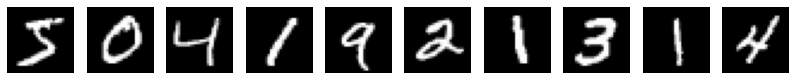

In [13]:
# データの表示

plt.clf()
fig = plt.figure(figsize=(14, 1.4))
for c in range(10):
    ax = fig.add_subplot(1, 10, c + 1)
    ax.imshow(x_train[c].reshape(28, 28), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()
plt.show()

## ネットワークモデルの定義

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    grad = np.zeros(x.shape)
    grad[x > 0] = 1
    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        # x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    # x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

次に，上で定義した関数を用いてネットワークを定義します．
ここでは，入力層，中間層，出力層から構成される多層パーセプトロンとします．

入力層と中間層，出力層のユニット数は引数として与え，それぞれ`input_size`，`hidden_size`, `output_size`とします．
そして，`__init__`関数を用いて，ネットワークのパラメータを初期化します．
`w1`および`w2`は各層の重みで，`b1`および`b2`はバイアスを表しています．
重みは`randn`関数で，標準正規分布に従った乱数で生成した値を保有する配列を生成します．
バイアスは`zeros`関数を用いて，要素が全て0の配列を生成します．

そして，`forward`関数で，データを入力して結果を出力するための演算を定義します．

次に，`backward`関数ではパラメータの更新量を計算します．
まず，ネットワークの出力結果と教師ラベルから，誤差`dy`を算出します．
この時，教師ラベルをone-hotベクトルへ変換し，各ユニットの出力との差を取ることで，`dy`を計算しています．
その後，連鎖律に基づいて，出力層から順番に勾配を計算していきます．
このとき，パラメータの更新量を`self.grads`へ保存しておきます．

最後に`update_parameters`関数で，更新量をもとにパラメータの更新を行います．

In [15]:
class MLP:

    def __init__(self, input_size, hidden_size, output_size, act_func='sigmoid', w_std=0.01):
        self.w1 = w_std * np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.w2 = w_std * np.random.randn(hidden_size, hidden_size)
        self.b2 = np.zeros(hidden_size)
        self.w3 = w_std * np.random.randn(hidden_size, output_size)
        self.b3 = np.zeros(output_size)

        # 使用する活性化関数の選択
        if act_func == 'sigmoid':
            self.act = sigmoid
            self.act_grad = sigmoid_grad
        elif act_func == 'relu':
            self.act = relu
            self.act_grad = relu_grad
        else:
            print("ERROR")

        self.grads = {}

    def forward(self, x):
        self.h1 = np.dot(x, self.w1) + self.b1
        self.h2 = self.act(self.h1)
        self.h3 = np.dot(self.h2, self.w2) + self.b2
        self.h4 = self.act(self.h3)
        self.h5 = np.dot(self.h4, self.w3) + self.b3
        self.y = softmax(self.h5)
        return self.y

    def backward(self, x, t):
        batch_size = x.shape[0]
        self.grads = {}
        
        t = np.identity(10)[t]
        dy = (self.y - t) / batch_size

        self.grads['w3'] = np.dot(self.h4.T, dy)
        self.grads['b3'] = np.sum(dy, axis=0)

        d_h4 = np.dot(dy, self.w3.T)
        d_h3 = self.act_grad(self.h3) * d_h4
        self.grads['w2'] = np.dot(self.h2.T, d_h3)
        self.grads['b2'] = np.sum(d_h3, axis=0)
        
        d_h2 = np.dot(d_h3, self.w2.T)
        d_h1 = self.act_grad(self.h1) * d_h2
        self.grads['w1'] = np.dot(x.T, d_h1)
        self.grads['b1'] = np.sum(d_h1, axis=0)
        
    def update_parameters(self, lr=0.1):
        self.w1 -= lr * self.grads['w1']
        self.b1 -= lr * self.grads['b1']
        self.w2 -= lr * self.grads['w2']
        self.b2 -= lr * self.grads['b2']  
        self.w3 -= lr * self.grads['w3']
        self.b3 -= lr * self.grads['b3']  

## ネットワークの作成と学習の準備
上のプログラムで定義したネットワークを作成します．


まず，中間層と出力層のユニット数を定義します．
ここでは，入力層のユニット数`input_size`を学習データの次元，中間層のユニット数`hidden_size`を64，出力層のユニット数`output_size`を10とします．

各層のユニット数を`MLPMultinoulli`クラスの引数として与え，ネットワークを作成します．

In [16]:
input_size = x_train.shape[1]
hidden_size = 64
output_size = 10
model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, act_func='sigmoid')

## 学習
読み込んだMNISTデータセットと作成したネットワークを用いて，学習を行います．

1回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を20とします．

学習データは毎回ランダムに決定するため，numpyの`permutation`という関数を利用します．
各更新において，学習用データと教師データをそれぞれ`x_batch`と`y_batch`とします．
学習モデルに`x_batch`を与えて，`h`を取得します．
取得した`h`は精度および誤差を算出するための関数へと入力され，値を保存します．
そして，誤差を`backward`関数で逆伝播し，`update_parameters`でネットワークの更新を行います．

In [17]:
# 学習途中の精度を確認するための関数
def multiclass_classification_accuracy(pred, true):
    clf_res = np.argmax(pred, axis=1)
    return np.sum(clf_res == true).astype(np.float32)

# 学習中の誤差を確認するための関数
def cross_entropy(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


num_train_data = x_train.shape[0]
num_test_data = x_test.shape[0]
batch_size = 100
epoch_num = 10
learning_rate = 0.01

epoch_list = []
train_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

iteration = 0
for epoch in range(1, epoch_num + 1):
    
    sum_accuracy = 0.0
    sum_loss = 0.0
    
    perm = np.random.permutation(num_train_data)
    for i in range(0, num_train_data, batch_size):
        x_batch = x_train[perm[i:i+batch_size]]
        y_batch = y_train[perm[i:i+batch_size]]
        
        y = model.forward(x_batch)
        sum_accuracy += multiclass_classification_accuracy(y, y_batch)
        sum_loss += cross_entropy(y, y_batch)
        
        model.backward(x_batch, y_batch)
        model.update_parameters(lr=learning_rate)

        iteration += 1
    
    print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch,
                                                               sum_loss / num_train_data,
                                                               sum_accuracy / num_train_data))
    
    test_correct_count = 0
    for i in range(num_test_data):
        input = x_test[i:i+1]
        label = y_test[i:i+1]
        y = model.forward(input)
        
        test_correct_count += multiclass_classification_accuracy(y, label)

    # 学習途中のlossと精度の保存
    epoch_list.append(epoch)
    train_loss_list.append(sum_loss / num_train_data)
    train_accuracy_list.append(sum_accuracy / num_train_data)
    test_accuracy_list.append(test_correct_count / num_test_data)

epoch: 1, mean loss: 0.023011243214301945, mean accuracy: 0.11206666666666666
epoch: 2, mean loss: 0.0229853780238992, mean accuracy: 0.11261666666666667
epoch: 3, mean loss: 0.02291224900177089, mean accuracy: 0.11796666666666666
epoch: 4, mean loss: 0.022526318495540675, mean accuracy: 0.20255
epoch: 5, mean loss: 0.02069866882127416, mean accuracy: 0.2241
epoch: 6, mean loss: 0.018201101360507038, mean accuracy: 0.2718333333333333
epoch: 7, mean loss: 0.016587325833566362, mean accuracy: 0.4582333333333333
epoch: 8, mean loss: 0.014772989764362901, mean accuracy: 0.54945
epoch: 9, mean loss: 0.012970680193186097, mean accuracy: 0.6247333333333334
epoch: 10, mean loss: 0.011606587897809455, mean accuracy: 0.6847


## テスト
学習したネットワークを用いて，テストデータに対する認識率の確認を行います．

In [18]:
count = 0
num_test_data = x_test.shape[0]

for i in range(num_test_data):
    x = np.array([x_test[i]], dtype=np.float32)
    t = y_test[i]
    y = model.forward(x)
    
    pred = np.argmax(y.flatten())
    
    if pred == t:
        count += 1
        
print("test accuracy: {}".format(count / num_test_data))

test accuracy: 0.7171


## 学習推移のグラフ化

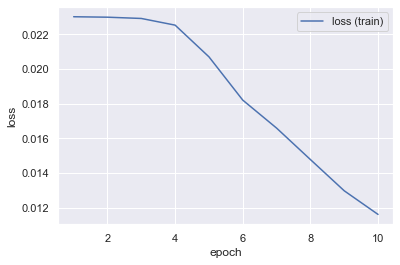

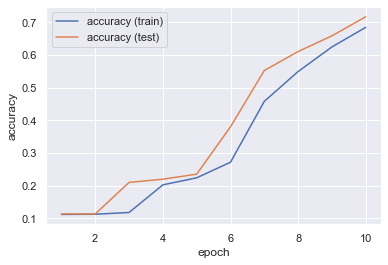

In [19]:
plt.figure()
plt.plot(epoch_list, train_loss_list, label='loss (train)')
plt.xlabel("epoch")     # x軸ラベル
plt.ylabel("loss")      # y軸ラベル
plt.legend()            # 凡例
plt.show()

plt.figure()
plt.plot(epoch_list, train_accuracy_list, label='accuracy (train)')
plt.plot(epoch_list, test_accuracy_list, label='accuracy (test)')
plt.xlabel("epoch")     # x軸ラベル
plt.ylabel("accuracy")  # y軸ラベル
plt.legend()            # 凡例
plt.show()